Treating layer(s) 8 incoherently
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


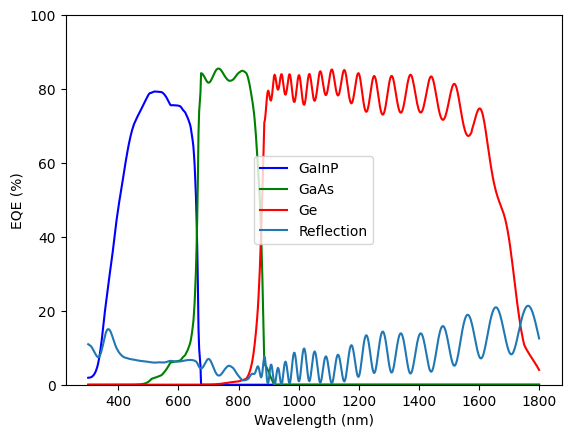

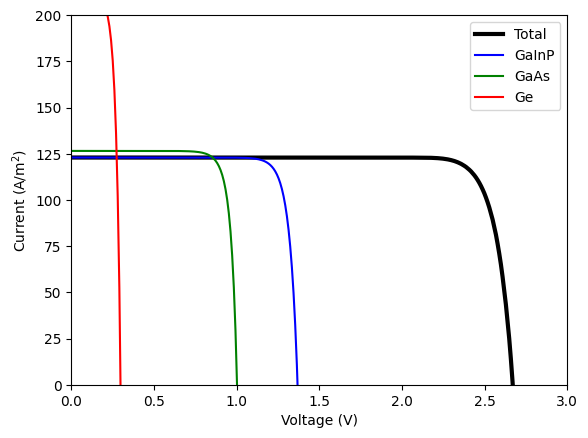

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from solcore import siUnits, material, si
from solcore.interpolate import interp1d
from solcore.solar_cell import SolarCell
from solcore.structure import Junction, Layer
from solcore.solar_cell_solver import solar_cell_solver

all_materials = []


def this_dir_file(f):
    from pathlib import Path
    return str(Path(__file__).parent / "data" /  f)


# We need to build the solar cell layer by layer.
# We start from the AR coating. In this case, we load it from an an external file
refl_nm = np.loadtxt(this_dir_file("MgF-ZnS_AR.csv"), unpack=True, delimiter=",")
ref = interp1d(x=siUnits(refl_nm[0], "nm"), y=refl_nm[1], bounds_error=False, fill_value=0)

# TOP CELL - GaInP
# Now we build the top cell, which requires the n and p sides of GaInP and a window layer.
# We also load the absorption coefficient from an external file. We also add some extra parameters needed for the
# calculation such as the minority carriers diffusion lengths
AlInP = material("AlInP")
InGaP = material("GaInP")
window_material = AlInP(Al=0.52)
top_cell_n_material = InGaP(In=0.49, Nd=siUnits(2e18, "cm-3"), hole_diffusion_length=si("200nm"))
top_cell_p_material = InGaP(In=0.49, Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("1um"))

all_materials.append(window_material)
all_materials.append(top_cell_n_material)
all_materials.append(top_cell_p_material)

# MID CELL  - InGaAs
# We add manually the absorption coefficient of InGaAs since the one contained in the database doesn't cover
# enough range, keeping in mind that the data has to be provided as a function that takes wavelengths (m) as input and
# returns absorption (1/m)
InGaAs = material("InGaAs")
InGaAs_alpha = np.loadtxt(this_dir_file("in01gaas.csv"), unpack=True, delimiter=",")
InGaAs.alpha = interp1d(x=1240e-9 / InGaAs_alpha[0][::-1], y=InGaAs_alpha[1][::-1], bounds_error=False, fill_value=0)

mid_cell_n_material = InGaAs(In=0.01, Nd=siUnits(3e18, "cm-3"), hole_diffusion_length=si("500nm"))
mid_cell_p_material = InGaAs(In=0.01, Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("5um"))

all_materials.append(mid_cell_n_material)
all_materials.append(mid_cell_p_material)

# BOTTOM CELL - Ge
# We add manually the absorption coefficient of Ge since the one contained in the database doesn't cover
# enough range.
Ge = material("Ge")
Ge_alpha = np.loadtxt(this_dir_file("Ge-Palik.csv"), unpack=True, delimiter=",")
Ge.alpha = interp1d(x=1240e-9 / Ge_alpha[0][::-1], y=Ge_alpha[1][::-1], bounds_error=False, fill_value=0)

bot_cell_n_material = Ge(Nd=siUnits(2e18, "cm-3"), hole_diffusion_length=si("800nm"))
bot_cell_p_material = Ge(Na=siUnits(1e17, "cm-3"), electron_diffusion_length=si("50um"))

all_materials.append(bot_cell_n_material)
all_materials.append(bot_cell_p_material)

# We add some other properties to the materials, assumed the same in all cases, for simplicity.
# If different, we should have added them above in the definition of the materials.
for mat in all_materials:
    mat.hole_mobility = 5e-2
    mat.electron_mobility = 3.4e-3
    mat.hole_mobility = 3.4e-3
    mat.electron_mobility = 5e-2
    mat.relative_permittivity = 9

# And, finally, we put everything together, adding also the surface recombination velocities. We also add some shading
# due to the metallisation of the cell = 8%, and indicate it has an area of 0.7x0.7 mm2 (converted to m2)
solar_cell = SolarCell(
    [
        Junction([Layer(si("25nm"), material=window_material, role='window'),
                  Layer(si("100nm"), material=top_cell_n_material, role='emitter'),
                  Layer(si("600nm"), material=top_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
        Junction([Layer(si("200nm"), material=mid_cell_n_material, role='emitter'),
                  Layer(si("3000nm"), material=mid_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
        Junction([Layer(si("400nm"), material=bot_cell_n_material, role='emitter'),
                  Layer(si("100um"), material=bot_cell_p_material, role='base'),
                  ], sn=1, sp=1, kind='DA'),
    ], reflectivity=ref, shading=0.08, cell_area=0.7 * 0.7 / 1e4)

wl = np.linspace(300, 1800, 700) * 1e-9
solar_cell_solver(solar_cell, 'qe', user_options={'wavelength': wl})

plt.figure(1)
plt.plot(wl * 1e9, solar_cell[0].eqe(wl) * 100, 'b', label='GaInP')
plt.plot(wl * 1e9, solar_cell[1].eqe(wl) * 100, 'g', label='InGaAs')
plt.plot(wl * 1e9, solar_cell[2].eqe(wl) * 100, 'r', label='Ge')

plt.legend()
plt.ylim(0, 100)
plt.ylabel('EQE (%)')
plt.xlabel('Wavelength (nm)')

V = np.linspace(0, 3, 300)
solar_cell_solver(solar_cell, 'iv', user_options={'voltages': V, 'light_iv': True, 'wavelength': wl})

plt.figure(2)
plt.plot(V, solar_cell.iv['IV'][1], 'k', linewidth=3, label='Total')
plt.plot(V, -solar_cell[0].iv(V), 'b', label='GaInP')
plt.plot(V, -solar_cell[1].iv(V), 'g', label='InGaAs')
plt.plot(V, -solar_cell[2].iv(V), 'r', label='Ge')

plt.legend()
plt.ylim(0, 200)
plt.xlim(0, 3)
plt.ylabel('Current (A/m$^2$)')
plt.xlabel('Voltage (V)')

plt.show()